1. dgl
2. torch_geometric
3. networkx
4. MLP 佐藤先生　「グラフニューラルネットワーク」
5. ヤオ・マー　「グラフ深層学習」
6. ビショップ　"Deep Learning"

# 第二章　グラフの表現方法

このチュートリアルでは、以下の内容を学ぶ。

- DGLを使用してグラフをゼロから構築する。
- グラフにノードとエッジの特徴を割り当てる。
- ノードの次数や接続性など、DGLグラフのプロパティを抽出する。
- DGLグラフを別のグラフに変換する。
- DGLグラフをロードして保存する。

## DGLを用いたグラフの構築

DGLは、```DGLGraph```オブジェクトとして有向グラフを表す。  
グラフのノード数とソースノードとターゲットノードのリストを指定してグラフを構築することができる。  
グラフのノードは、0から始まる連続したIDを持る。  

例えば、次のコードは、5つの葉を持つ有向スターグラフを構築する。  
中心ノードのIDは0で、エッジは中心ノードから葉に向かう。  

# DGLとは?

AWSが開発しているPytorch-basedの(Tensorflowもサポート)グラフを対称としたライブラリです。

In [1]:
# ライブラリのインポート
import os

os.environ["DGLBACKEND"] = "pytorch" # バックエンドとしてPytorch, Tensorflow, MXNetを指定可能。今回はPytorch
import dgl
import numpy as np
import torch

In [13]:
# グラフオブジェクトの作成
g = dgl.graph(data=([0, 0, 0, 0, 0,], [1, 2, 3, 4, 5]), num_nodes=6) # 6つのノードと5つのエッジを持つスターグラフ

# あるいは、torch.Tensorを使っても作成可能  
g = dgl.graph(data=(torch.tensor([0, 0, 0, 0, 0,]), torch.tensor([1, 2, 3, 4, 5])), num_nodes=6) # 6つのノードと5つのエッジを持つスターグラフ

# num_nodesを指定しない場合は、エッジリストから自動的にノード数を決定
g = dgl.graph(data=([0, 0, 0, 0, 0,], [1, 2, 3, 4, 5])) # 6つのノードと5つのエッジを持つスターグラフ    

In [14]:
g.num_nodes()

6

In [15]:
type(g) # グラフオブジェクトの型を確認

dgl.heterograph.DGLGraph

**これらはすべて同じグラフを表している**

グラフ内のエッジは、0から始まる連続したIDを持ち、作成時にソースノードとターゲットノードのリストと同じ順序で配置される。



In [16]:
# Print the source and destination nodes of every edge.
print(g.edges())

(tensor([0, 0, 0, 0, 0]), tensor([1, 2, 3, 4, 5]))


# グラフの可視化

networkxを使用してグラフを可視化することができる。

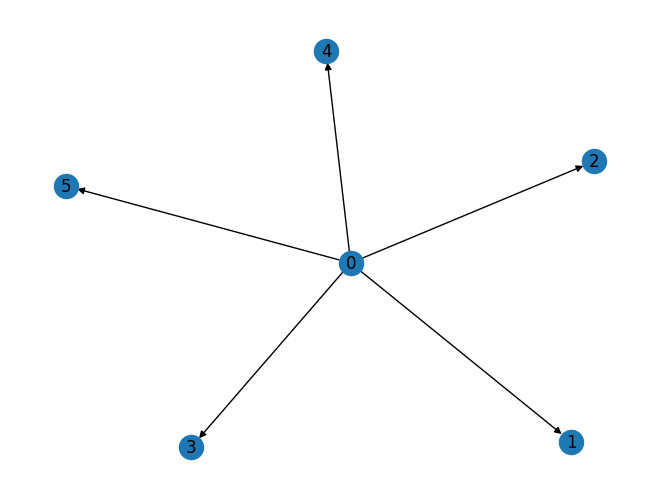

In [17]:
import networkx as nx
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib

# DGLグラフをNetworkXグラフに変換
nx_g = g.to_networkx()
# NetworkXグラフを描画
nx.draw(nx_g, with_labels=True)

<div class="alert alert-info"><h4>Note</h4><p>``DGLGraph``'s are always directed to best fit the computation
   pattern of graph neural networks, where the messages sent
   from one node to the other are often different between both
   directions. If you want to handle undirected graphs, you may consider
   treating it as a bidirectional graph. See `Graph
   Transformations`_ for an example of making
   a bidirectional graph.</p></div>




## グラフにノードとエッジの特徴量を割り当てる

多くのグラフデータには、ノードとエッジに属性が含まれている。  
実世界では、ノードやエッジの属性の種類は任意だが、``DGLGraph`` はテンソル（数値の内容を持つ）に格納された属性のみを受け入れる。  
そのため、すべてのノードやエッジの属性は同じ形状を持たなければならない。  
深層学習の文脈では、これらの属性はしばしば*特徴量*と呼ばれる。


特徴量は、``ndata`` と ``edata`` インターフェイスを介してそれぞれノードとエッジの特徴を割り当てて取得することができる。


In [18]:
# 各ノードに3次元の特徴ベクトルを割り当てる
g.ndata["x"] = torch.randn(6, 3)
# 各エッジに4次元の特徴ベクトルを割り当てる
g.edata["a"] = torch.randn(5, 4)
# 各ノードに5x4の特徴行列を割り当てる。DGLのノードとエッジの特徴は多次元のものも扱える。
g.ndata["y"] = torch.randn(6, 5, 4)

print(g.edata["a"])

tensor([[ 0.2513, -0.8722, -1.2169, -0.4538],
        [-1.5571,  0.2657, -1.2836,  0.1658],
        [ 0.9459, -0.0913,  0.6221,  0.4202],
        [-0.4265, -2.7702,  0.2505, -0.5672],
        [ 1.8105, -0.2867,  0.8203, -1.5970]])


<div class="alert alert-info"><h4>Note</h4><p>The vast development of deep learning has provided us many
   ways to encode various types of attributes into numerical features.
   Here are some general suggestions:

   -  For categorical attributes (e.g. gender, occupation), consider
      converting them to integers or one-hot encoding.
   -  For variable length string contents (e.g. news article, quote),
      consider applying a language model.
   -  For images, consider applying a vision model such as CNNs.

   You can find plenty of materials on how to encode such attributes
   into a tensor in the [PyTorch Deep Learning
   Tutorials](https://pytorch.org/tutorials/)_.</p></div>




## グラフ構造から情報を抽出する

``DGLGraph`` オブジェクトから、グラフ構造に関わる情報を取得できる。

In [19]:
print(g.num_nodes()) # ノード数を確認
print(g.num_edges()) # エッジ数を確認
# 中心ノードの出次数 (out degree) を確認
print(g.out_degrees(0))
# 中心ノードの入次数 (in degree) を確認
print(g.in_degrees(0))

6
5
5
0


## グラフ変換




DGLは、グラフを別のグラフに変換するための多くのAPIを提供している。

In [20]:
# グラフからノード0, ノード1, ノード3を抽出してサブグラフを作成
sg1 = g.subgraph([0, 1, 3]) # ノード0, ノード1, ノード3を抽出
# グラフからエッジ0, エッジ1, エッジ3を抽出してサブグラフを作成
sg2 = g.edge_subgraph([0, 1, 3])

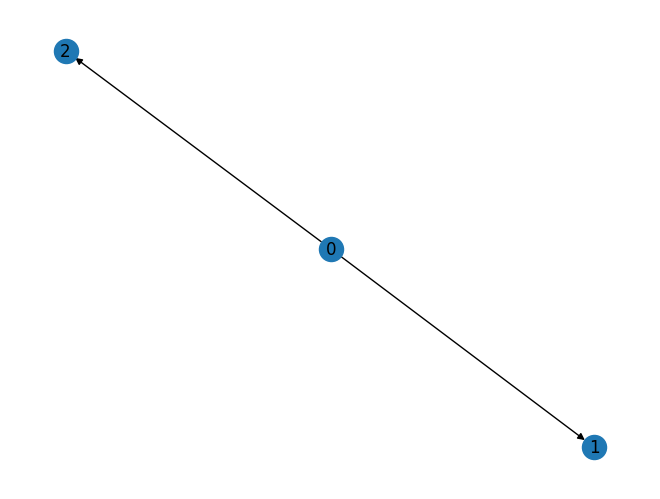

In [21]:
# DGLグラフをNetworkXグラフに変換
nx_sg1 = sg1.to_networkx()
# NetworkXグラフを描画
nx.draw(nx_sg1, with_labels=True)

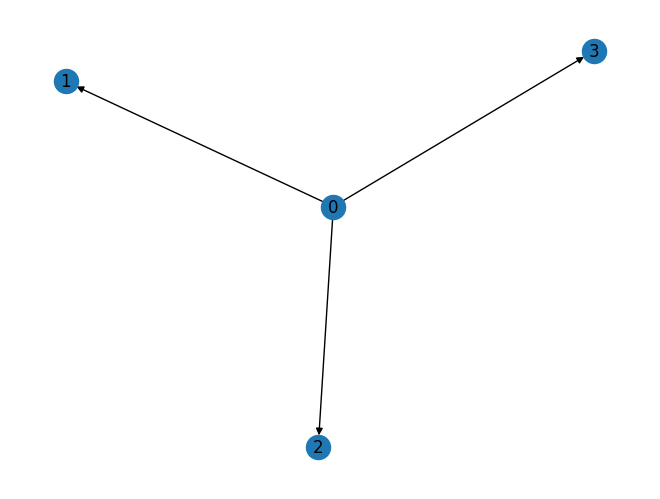

In [22]:
nx_sg2 = sg2.to_networkx()
# NetworkXグラフを描画
nx.draw(nx_sg2, with_labels=True)

新しいグラフ内のノード/エッジのマッピングを、新しいグラフ内のノード特徴``dgl.NID``またはエッジ特徴``dgl.EID``を見ることで取得することができる。

In [23]:
# サブグラフsg1の各ノードの元のID
print(sg1.ndata[dgl.NID])
# サブグラフsg1の各エッジの元のID
print(sg1.edata[dgl.EID])
# サブグラフsg2の各ノードの元のID
print(sg2.ndata[dgl.NID])
# サブグラフsg2の各エッジの元のID
print(sg2.edata[dgl.EID])

tensor([0, 1, 3])
tensor([0, 2])
tensor([0, 1, 2, 4])
tensor([0, 1, 3])


```subgrapg``` と ```edge_subgraph``` は、元の特徴をサブグラフに複製している

In [28]:
# The original node feature of each node in sg1
print(sg1.ndata["x"])
# The original edge feature of each node in sg1
print(sg1.edata["a"])
# The original node feature of each node in sg2
print(sg2.ndata["x"])
# The original edge feature of each node in sg2
print(sg2.edata["a"])

tensor([[-0.6215, -0.1593,  1.5185],
        [ 0.0481, -0.1835, -0.3256],
        [-0.0320, -1.9963, -0.6372]])
tensor([[ 0.2513, -0.8722, -1.2169, -0.4538],
        [ 0.9459, -0.0913,  0.6221,  0.4202]])
tensor([[-0.6215, -0.1593,  1.5185],
        [ 0.0481, -0.1835, -0.3256],
        [ 0.3945, -0.6825, -0.0131],
        [-0.7535, -0.8769, -0.1957]])
tensor([[ 0.2513, -0.8722, -1.2169, -0.4538],
        [-1.5571,  0.2657, -1.2836,  0.1658],
        [-0.4265, -2.7702,  0.2505, -0.5672]])


よくある変換のもう一つは、元のグラフの各エッジに対して``dgl.add_reverse_edges``を用いて逆向きのエッジを追加することである。


<div class="alert alert-info"><h4>Note</h4><p>If you have an undirected graph, it is better to convert it
   into a bidirectional graph first via adding reverse edges.</p></div>




In [40]:
# 無向グラフを作成するために、逆向きのエッジを追加
newg = dgl.add_reverse_edges(g)
print(newg.edges())

(tensor([0, 0, 0, 0, 0, 1, 2, 3, 4, 5]), tensor([1, 2, 3, 4, 5, 0, 0, 0, 0, 0]))


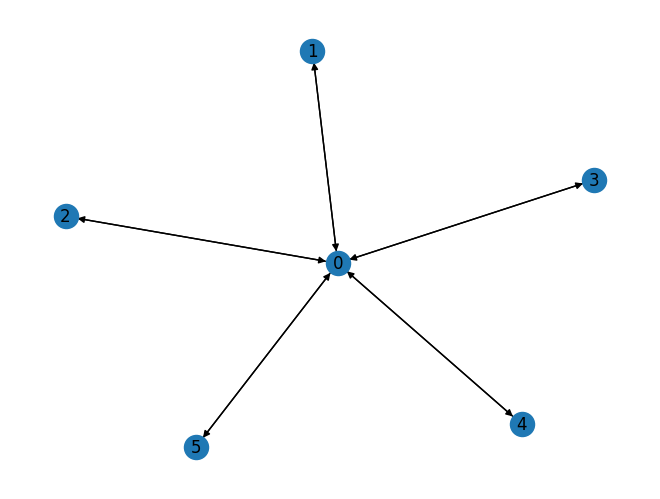

In [42]:
nx_newg = newg.to_networkx()
# NetworkXグラフを描画
nx.draw(nx_newg, with_labels=True)

## グラフの保存と読み込み

グラフ、あるいはグラフのリストは、```dgl.save_graphs```で保存し、```dgl.load_graphs```で読み込むことができる。

In [11]:
# グラフを保存
dgl.save_graphs("graph.dgl", g)
dgl.save_graphs("graphs.dgl", [g, sg1, sg2])

# グラフを読み込み
(g,), _ = dgl.load_graphs("graph.dgl")
print(g)
(g, sg1, sg2), _ = dgl.load_graphs("graphs.dgl")
print(g)
print(sg1)
print(sg2)

Graph(num_nodes=6, num_edges=5,
      ndata_schemes={'y': Scheme(shape=(5, 4), dtype=torch.float32), 'x': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'a': Scheme(shape=(4,), dtype=torch.float32)})
Graph(num_nodes=6, num_edges=5,
      ndata_schemes={'y': Scheme(shape=(5, 4), dtype=torch.float32), 'x': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'a': Scheme(shape=(4,), dtype=torch.float32)})
Graph(num_nodes=3, num_edges=2,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'y': Scheme(shape=(5, 4), dtype=torch.float32), 'x': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'a': Scheme(shape=(4,), dtype=torch.float32)})
Graph(num_nodes=4, num_edges=3,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'y': Scheme(shape=(5, 4), dtype=torch.float32), 'x': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'a': Scheme

## What’s next?

-  See
   `here <apigraph-querying-graph-structure>`
   for a list of graph structure query APIs.
-  See
   `here <api-subgraph-extraction>`
   for a list of subgraph extraction routines.
-  See
   `here <api-transform>`
   for a list of graph transformation routines.
-  API reference of :func:`dgl.save_graphs`
   and
   :func:`dgl.load_graphs`




In [12]:
# Thumbnail credits: Wikipedia
# sphinx_gallery_thumbnail_path = '_static/blitz_2_dglgraph.png'